This notebook has the purpose of explaining how the app IndieGOGO, for the prediction of campaign success, works.


The strategy consists in:
1. collecting a series of campaign ads from the IndieGOGO website,
2. extracting the terms frequency in the ads corpus using a TD-IDF vectorizer,
3. training a logistic regression classifier using the corpus terms as features and the success of a campaign as label (0 if unsuccessful, 1 if successful),
4. using the model to determine whether a campaign (chosen by the user) will be successful or not.

The campaign dataset is created scraping the IndieGOGO website with BeautifulSoup and Selenium. A future version of the app will only use BeautifulSoup, as it will rely on the page json file (more details below).

As a first step, we connect to the Postgres database that contains the campaign dataset.
The login details are contained in a .config file that I keep on my local machine.

The dataset is dumped in a pandas dataframe, and contains three columns: the first two are the two sections of the campaign corpus identified, the last is the percentage of money collected by the campaign.

Usually the campaign ads contain an "Overview" section that is stored in the column "lower_case_span" and the actual ad corpus contained in "lower_case_div".
A lot of the websites scraped did not contain an overview section, therefore a lot of the respective rows are empty.

In [87]:
from sqlalchemy import create_engine
import configparser
import pandas as pd

configParser = configparser.RawConfigParser()
configFilePath = './login.config'
configParser.read(configFilePath)
user = configParser.get('dev-postgres-config', 'user')
password = configParser.get('dev-postgres-config', 'pwd')
host = configParser.get('dev-postgres-config', 'host')
port = configParser.get('dev-postgres-config', 'port')

print("Attempt to connect to PSQL at {}:{} as user '{}'".format(host, port, user))

engine = create_engine(
    'postgresql+psycopg2://' + user + ':' + password + '@' + host + ':' + port + '/indiegogo_url')
#Dump the campaign table into a pandas dataframe
df = pd.read_sql_query('select * from "idf_ml_set_complete"', con=engine)
#FIll Nans with 0.
df = df.fillna("0")
print()
print("Head of df:")
print(df.head())
print()
print("Length of df:")
print(len(df))

Attempt to connect to PSQL at postgres:5432 as user 'postgres'

Head of df:
  lower_case_span                                     lower_case_div  \
0              {}  {"why micky needs help.\nyesterday, my dog was...   
1              {}  {"\nshort summary\ncontributors fund ideas the...   
2              {}  {"\n\nfrankie needs all of the love and help h...   
3              {}  {"\nannouncement 5/17/13\nwe have surpassed ou...   
4              {}  {"i am a single mother that can't afford the c...   

  collected_percentage  
0                  100  
1                  130  
2                   80  
3                  128  
4                  105  

Length of df:
2351


The second step consists in the initialization of the TfidfVectorizer.
The vectorizer will be used to build a term frequency matrix,
which will have as many rows as the campaign ads scraped, and the
columns will correspond to the unigrams and bigrams that are present in less than 95% of the documents
but more than 3% of them. Also, stopwords are excluded.

Imposing these thresholds helps keeping the dimension of the vectorizer matrix contained.

In obtaining the terms frequency matrix, 'lower_case_span' and 'lower_case_div' are joined together.

In [88]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords_list = stopwords.words('english')
vectorizer = TfidfVectorizer(analyzer='word',
                             ngram_range=(1, 2),
                             max_df=0.95,
                             min_df=0.03,
                             stop_words=stopwords_list)

print('Vectorizer initialized.')
print('Building the term frequency matrix.')
print()
#'lower_case_span' and 'lower_case_div' are joined together.
tfidf_matrix = vectorizer.fit_transform(df['lower_case_span'] + " " + df['lower_case_div'])
sdf = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)
print("Dimensions of tfidf_matrix:")
print(sdf.shape)

Vectorizer initialized.
Building the term frequency matrix.

Dimensions of tfidf_matrix:
(2351, 1562)


The matrix contains the features that will be used to train the logistic regression classifier,
and it is dumped into a pandas dataframe because it is easier to manipulate.

Now it is the time to add the label column to the term frequency dataframe: whenever the collected percentage is less than 100% the campaign will be considered unsuccessful, therefore the label will be 0, 1 otherwise.

The percentage of money raised by the campaign is a string in which the thousand separator is a comma rather than a dot. This will be a problem when casting the column to float,
so before that we replace commas with dots across all the column.

In [89]:
#Addition of 'collected_percentage' column.
sdf['collected_percentage'] = df['collected_percentage']

#Replacement of commas with dots
sdf['collected_percentage'] = sdf['collected_percentage'].str.replace(",", ".")

#Cast the column to float, create new column with 1 or 0
# based on the campaign success.
sdf['collected_percentage_binary'] = [1 if x > 100 else 0 for x in
                                      sdf['collected_percentage'].astype(float)]
print("Dimensions of tfidf_matrix:")

print(sdf.shape)

Dimensions of tfidf_matrix:
(2351, 1564)


The matrix is fed into a logistic regression classifier, that performs a 5-fold cross validation.
Because the labels are imbalanced, class weights are added.

The score of the model is returned, with the scoring method being the area under the ROC curve.
The ROC curve is also displayed, and below it you can find the confusion matrix.

In [90]:
#Proof of class imbalance:
ones_weight = len(sdf[sdf['collected_percentage_binary'] == 1])
zeroes_weight = len(sdf[sdf['collected_percentage_binary'] == 0])
print("Number of ones:", ones_weight)
print("Number of zeroes:", zeroes_weight)

Number of ones: 1646
Number of zeroes: 705


Finished training classifier.
Score: 0.9996962332928311
Confusion Matrix:
[[ 705    0]
 [   1 1645]]


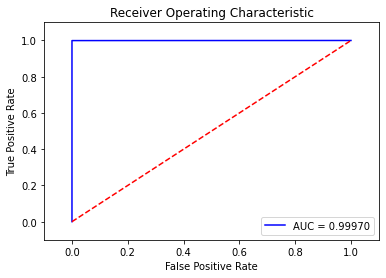

In [91]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import matplotlib.pyplot as plt

X = sdf.drop(columns=["collected_percentage", "collected_percentage_binary"])
y = sdf['collected_percentage_binary']
clf = LogisticRegressionCV(cv=5, class_weight='balanced', max_iter=1000).fit(X, y)

print('Finished training classifier.')
y_pred = clf.predict(X)
confusion_matrix = confusion_matrix(y, y_pred)

fpr, tpr, threshold = sklearn.metrics.roc_curve(y, y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
print('Score:', roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('Confusion Matrix:')
print(confusion_matrix)

An almost perfect AUC ROC might imply that the model is overfitting the data, therefore a higher number of data points is needed?

Now that we have the classifier trained, we can proceed
with testing the model using a campaign ad chosen by the user.

The user provides the link to a campaign ad, which is scraped using BeautifulSoup.
Rather than using Selenium to load the parts of the page accessible only after pushing a button,
the program extracts the project_id and proceeds with scraping the webpage in json format, accessible with the project id.

In [92]:
from bs4 import BeautifulSoup
import requests
import re
import json
import pandas as pd
import numpy as np

#Link to the campaign as chosen by the user.
url = 'https://www.indiegogo.com//projects/homefarm-the-ultimate-in-home-cultivation-food-cooking'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
json_data = soup.find('script', text=re.compile("//<!\[CDATA\["))
pattern = ',"project_id":(.*)};gon.tracking_info={'
#The webpage is scraped to obtain the project_id
project_id = re.search(pattern, str(json_data)).group(1)
#The project id is used to access the json format of the webpage,
#containing the whole ad corpus.
page = requests.get("https://www.indiegogo.com/private_api/campaigns/" + project_id + "/description")
soup = BeautifulSoup(page.content, 'html.parser')
dict_json = json.loads(str(soup))
html_str = dict_json['response']['description_html']
#The ad corpus is transformed into a string
soup_text = BeautifulSoup(html_str, "html.parser").get_text()

The corpus of the desired ad website has to be integrated with the whole
campaign dataset in order to get a consistent TF_IDF matrix.

The newly scraped ad corpus is therefore inserted into a pandas dataframe and appended to the campaign dataset

Notice that because the scraping method changed, the newly scraped website will not have 'lower_case_span' and 'lower_case_div'
components, but just a single string that encompasses the whole ad.

That is why 'lower_case_span' is set to be an empty string, while 'lower_case_div' consists of the whole corpus.

The collected percentage of the campaign is set to np.Nan.

The vectorizer already used to create the TF-IDF matrix is re-used in order to extract the features of the user input website consistently
with the rest of the dataset.

In [93]:
#User input appended to campaign dataframe.
#For consistency, the ad corpus is set to lowercase.
temp_dict = [
    {
        'lower_case_span': str(),
        'lower_case_div': soup_text.lower(),
        'collected_percentage': np.NaN
    }
]

temp = pd.DataFrame.from_records(temp_dict)
df_to_pred = pd.concat([df, temp])
df_to_pred = df_to_pred.reset_index(drop=True)
tfidf_matrix_to_pred = vectorizer.fit_transform(df_to_pred['lower_case_span'] + " " + df_to_pred['lower_case_div'])
print("Matrix created.")

Matrix created.


As before, the matrix is transformed into a dataframe, and the 'collected_percentage' column is added.

In [94]:
sdf = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix_to_pred)
sdf['collected_percentage'] = df_to_pred['collected_percentage']

print("Dimensions of tfidf_matrix_to_pred:")
print(sdf.shape)

Dimensions of tfidf_matrix_to_pred:
(2352, 1563)


You can observe that the number of rows of the dataframe is one more that before (as expected).

The dataframe row we are interested in for our prediction is the only one with a np.Nan value as a collected percentage, therefore that is the only row we will retain:

In [95]:
#Selecting the Nan collected_percentage value of all the dataframe.
X_to_pred = sdf[sdf.isnull().any(1)]

The collected_percentage column is then dropped, so that we are left with only the features
of the user input campaign ad, ready to be fed into the classifier:

In [96]:
#Eliminate collected_percentage to only retain the ad's features.
X_to_pred = X_to_pred.drop(columns=["collected_percentage"])
#Prediction
res = clf.predict(X_to_pred)

Finally, the prediction is displayed, showing "The campaign will be unsuccessful :(" if the predicted value is 0,
"The campaign will be successful!!" otherwise.

In [97]:
if res[0] == 0:
    output_logreg = "The campaign will be unsuccessful :("
else:
    output_logreg = "The campaign will be successful!!"

print(output_logreg)


The campaign will be unsuccessful :(
